In [1]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:

# Adjust display options
#pd.set_option('display.max_rows', 600)  # Display all rows
#pd.set_option('display.max_columns', None)  # Display all columns
#pd.set_option('display.width', None)  # Allow unlimited width for display

# Initialize empty list 
dfs = []
participant_ids = []

# Iterate through each CSV file in the folder
pathlist = Path("data/").rglob('*.csv')
for participant_id, path in enumerate(pathlist, start=1):
    df = pd.read_csv(path)
    dfs.append(df)
    participant_ids.extend([participant_id] * len(df))

# Concatenate all DataFrames in the list into one DataFrame
combined_df = pd.concat(dfs, ignore_index=True)
combined_df['participant_id'] = participant_ids
print(combined_df)

# Reorder columns to place participant ID column first
cols = combined_df.columns.tolist()
cols = ['participant_id'] + [col for col in cols if col != 'participant_id']
combined_df = combined_df[cols]

# Clean data
combined_df = combined_df.dropna()
combined_df = combined_df[combined_df.rt != -1]

true_false_lst = []
# Iterate through each participant
for i in range(1, max(combined_df.participant_id) + 1):
    # Filter the DataFrame for the current participant
    participant_data = combined_df[combined_df.participant_id == i]
    
    # Count the True and False answers for the current participant
    true_count = participant_data['correct'].eq(True).sum()
    false_count = participant_data['correct'].eq(False).sum()
    
    # Create a dictionary with the counts
    bool_dict = {
        "Participant": i,
        "True": true_count,
        "False": false_count
    }
    
    # Append the dictionary to the list
    true_false_lst.append(bool_dict)
    
df_or = combined_df[combined_df.task_type != "or"]
df_mov = combined_df[combined_df.task_type != "mov"]

combined_df
#for entry in true_false_lst:
#    print(entry)


        rt key_press  correct  coherent_movement_direction  \
0     1167         j     True                          180   
1     1164         f     True                          180   
2     1502         j     True                          180   
3     1155         j     True                            0   
4      727         j     True                            0   
...    ...       ...      ...                          ...   
3067  1358         f     True                          180   
3068  1694         f     True                          180   
3069   619         f     True                          180   
3070   565         j     True                            0   
3071  1474         j     True                            0   

      coherent_orientation task_type task_transition   congruency  \
0                        0        or             NaN  incongruent   
1                      180        or      repetition    congruent   
2                        0        or      repeti

,participant_id,rt,key_press,correct,coherent_movement_direction,coherent_orientation,task_type,task_transition,congruency
1,1,1164,f,True,180,180,or,repetition,congruent
2,1,1502,j,True,180,0,or,repetition,incongruent
3,1,1155,j,True,0,0,mov,switch,congruent
4,1,727,j,True,0,0,mov,repetition,congruent
5,1,677,j,True,0,0,mov,repetition,congruent
...,...,...,...,...,...,...,...,...,...
3067,32,1358,f,True,180,180,mov,switch,congruent
3068,32,1694,f,True,180,180,or,switch,congruent
3069,32,619,f,True,180,0,mov,switch,incongruent
3070,32,565,j,True,0,180,mov,repetition,incongruent


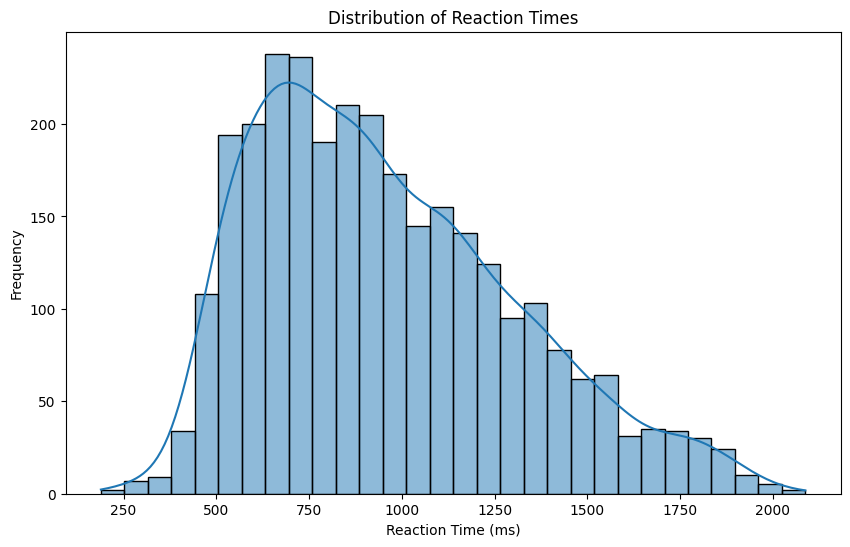

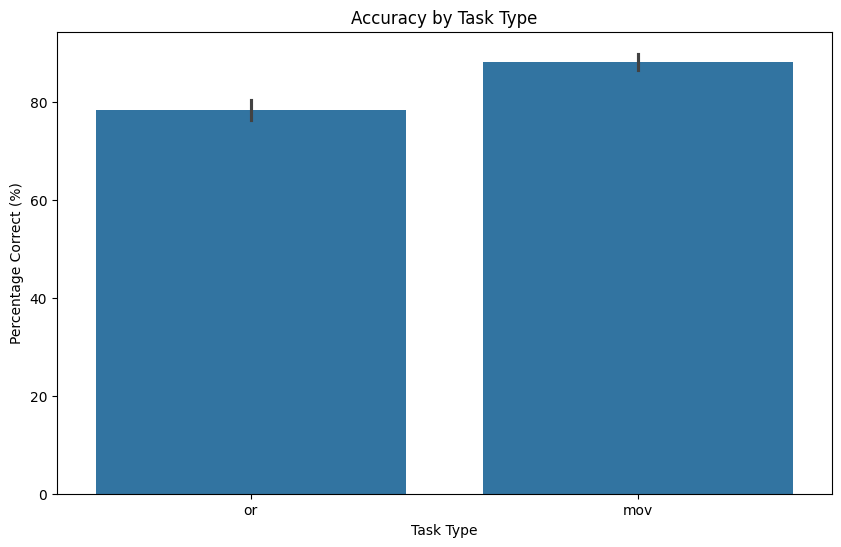

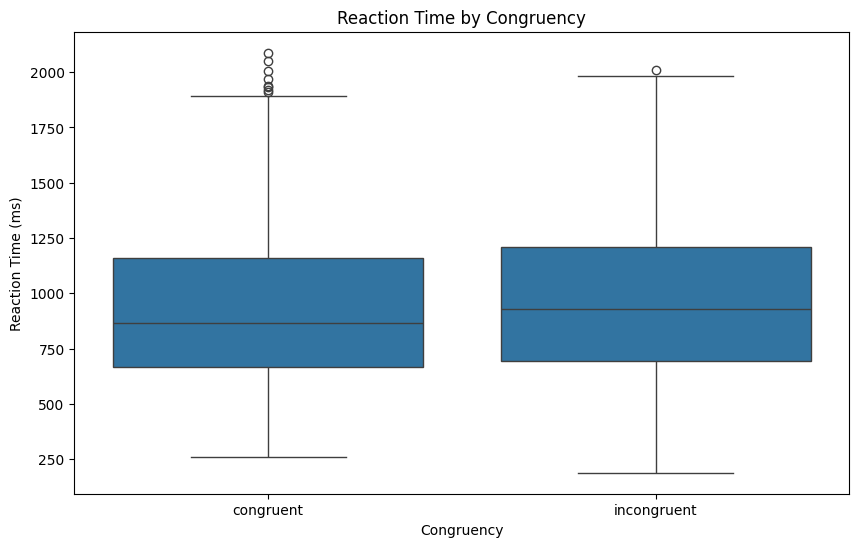

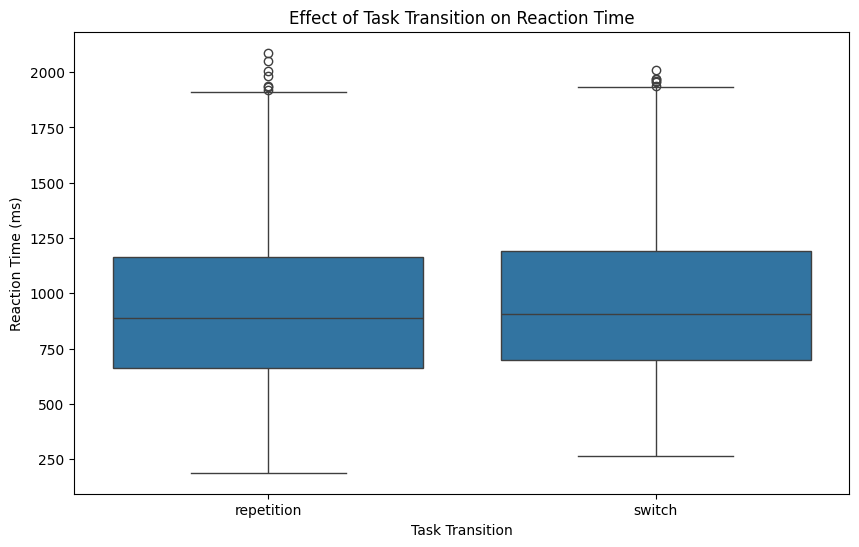

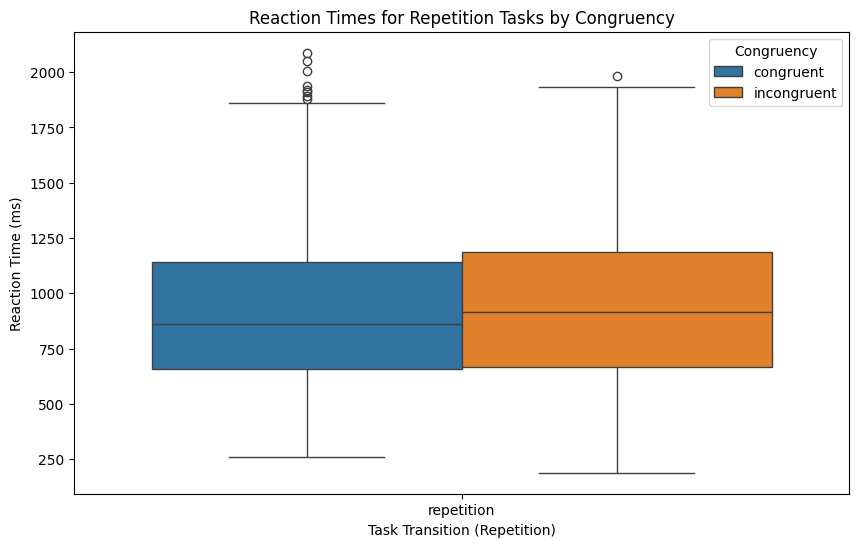

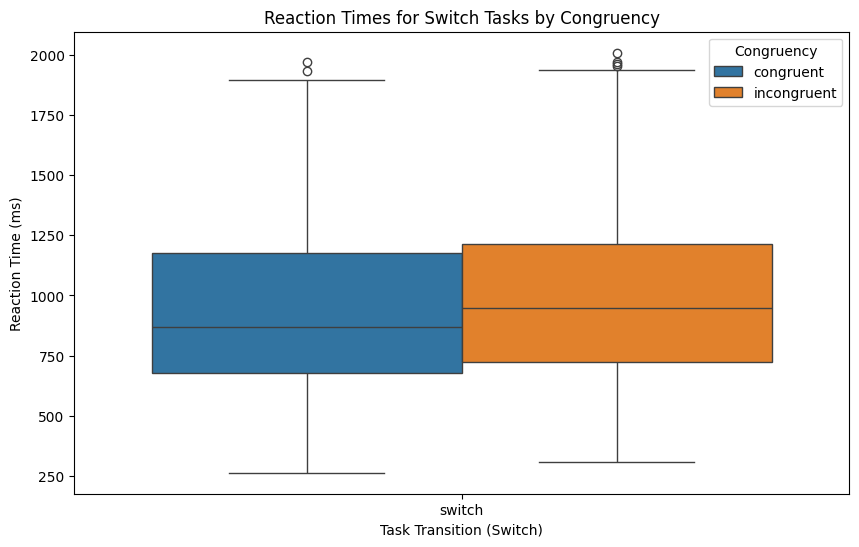

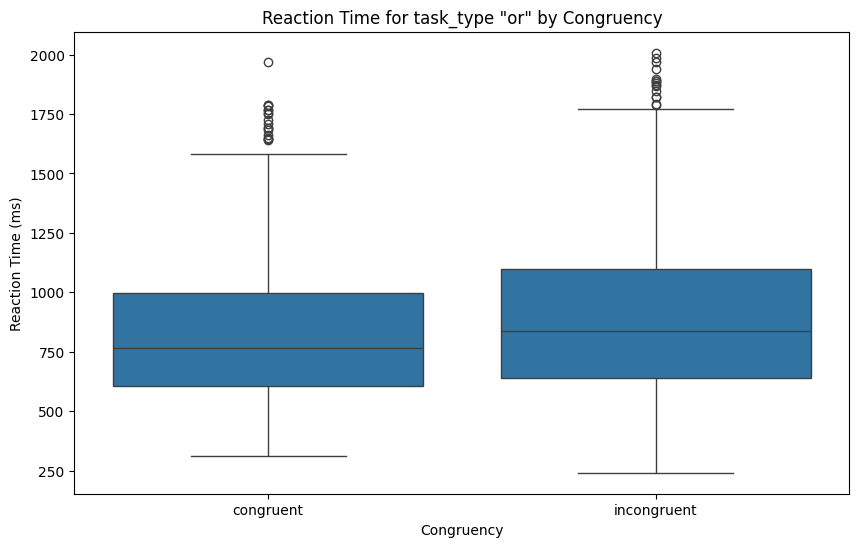

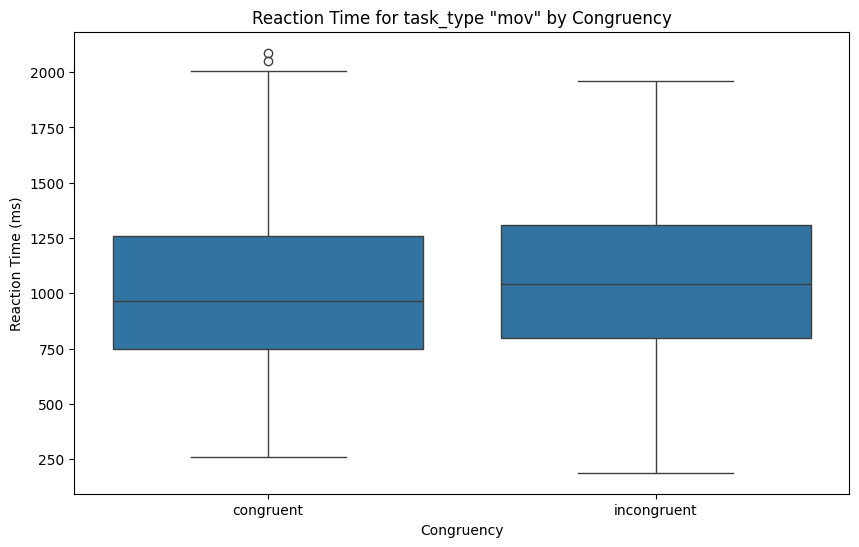

In [3]:
# Visualization 1: Distribution of Reaction Times
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_df, x="rt", kde=True, bins=30)
plt.title('Distribution of Reaction Times')
plt.xlabel('Reaction Time (ms)')
plt.ylabel('Frequency')
plt.show()

# Visualization 2: Accuracy by Task Type
plt.figure(figsize=(10, 6))
sns.barplot(x="task_type", y="correct", data=combined_df, estimator=lambda x: sum(x.astype(int)) / len(x) * 100)
plt.title('Accuracy by Task Type')
plt.xlabel('Task Type')
plt.ylabel('Percentage Correct (%)')
plt.show()

# Visualization 3: Reaction Time by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="congruency", y="rt", data=combined_df)
plt.title('Reaction Time by Congruency')
plt.xlabel('Congruency')
plt.ylabel('Reaction Time (ms)')
plt.show()

# Visualization 4: Task Transition Effects on Reaction Time
plt.figure(figsize=(10, 6))
sns.boxplot(x="task_transition", y="rt", data=combined_df)
plt.title('Effect of Task Transition on Reaction Time')
plt.xlabel('Task Transition')
plt.ylabel('Reaction Time (ms)')
plt.show()

# Visualization 5: Reaction Times for Repetition Tasks by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="task_transition", y="rt", hue="congruency", data=combined_df[combined_df['task_transition'] == 'repetition'])
plt.title('Reaction Times for Repetition Tasks by Congruency')
plt.xlabel('Task Transition (Repetition)')
plt.ylabel('Reaction Time (ms)')
plt.legend(title='Congruency')
plt.show()

# Visualization 6: Reaction Times for Switch Tasks by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="task_transition", y="rt", hue="congruency", data=combined_df[combined_df['task_transition'] == 'switch'])
plt.title('Reaction Times for Switch Tasks by Congruency')
plt.xlabel('Task Transition (Switch)')
plt.ylabel('Reaction Time (ms)')
plt.legend(title='Congruency')
plt.show()

# Visualization 7: Reaction Time for task_type "or" by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="congruency", y="rt", data=df_or)
plt.title('Reaction Time for task_type "or" by Congruency')
plt.xlabel('Congruency')
plt.ylabel('Reaction Time (ms)')
plt.show()

# Visualization 8: Reaction Time for task_type "mov" by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="congruency", y="rt", data=df_mov)
plt.title('Reaction Time for task_type "mov" by Congruency')
plt.xlabel('Congruency')
plt.ylabel('Reaction Time (ms)')
plt.show()

